In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [2]:
codes = pd.read_csv('../cleaned_csv/cases_district_key.csv')

# keep only the columns we need
codes = codes[['state_code', 'dist_code', 'pc11_district_id']]

# read the shapefile
shapes = gpd.read_file('../shapefiles/in_district.shp')

# convert dtcode11 to int
shapes['dtcode11'] = shapes['dtcode11'].astype(int, errors='ignore')

# read the types csv file
types = pd.read_csv('../csv/keys/keys/type_name_key.csv')
# drop unnecessary columns
types.drop(columns=['year', 'count'], inplace=True)

criminal_keywords = ['criminal', 'cr', 'cc', 'c.c.']
regex = '|'.join(criminal_keywords)

Crimes by geography

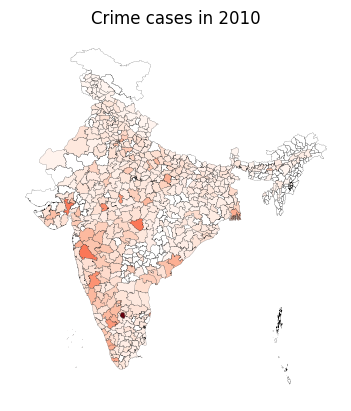

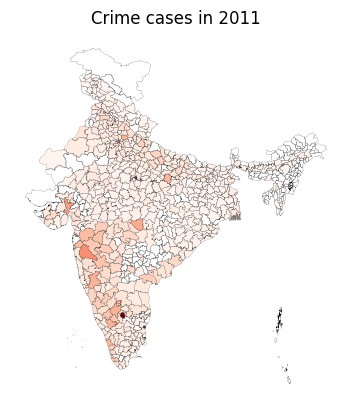

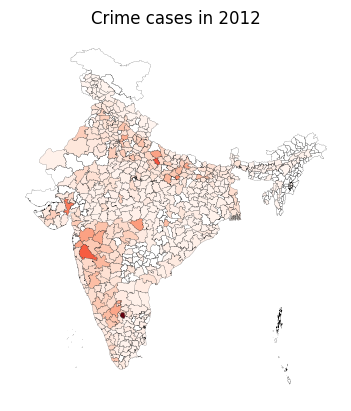

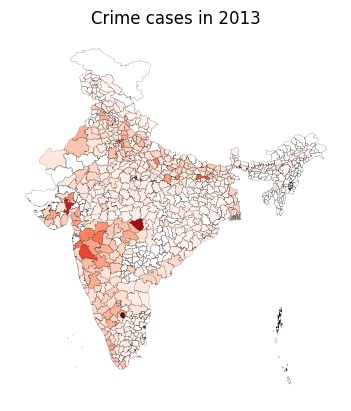

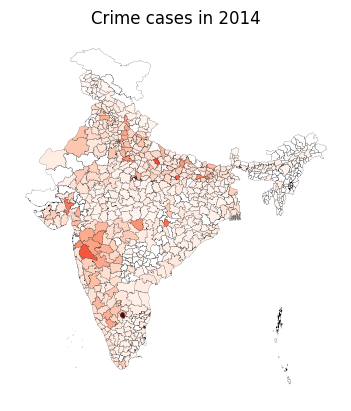

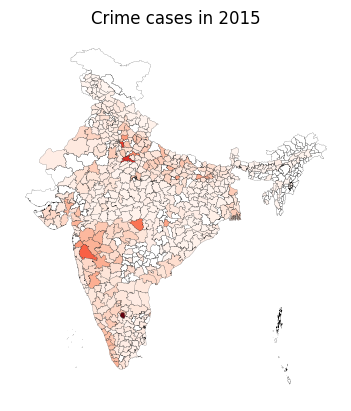

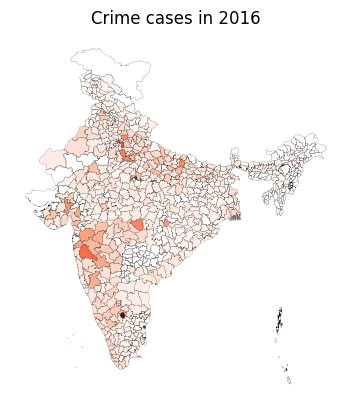

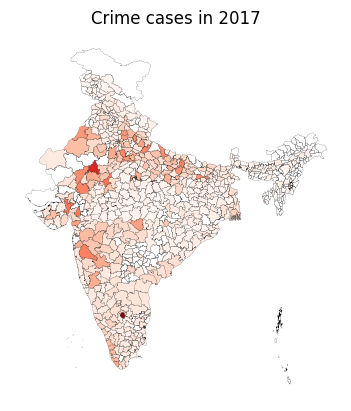

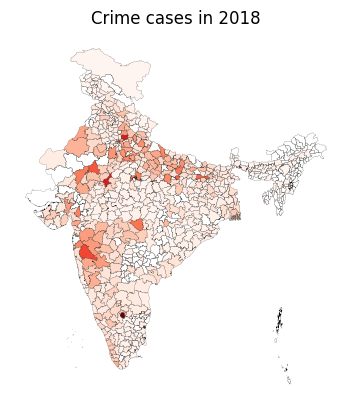

In [3]:
years = range(2010, 2018 + 1)
# years = [2016]

for year in years:

    df = pd.read_csv(f'../csv/cases/cases/small_cases_{year}.csv')

    # drop unnecessary columns
    df = df[['year', 'state_code', 'dist_code', 'type_name']]

    # add a column for criminal cases


    # merge the dataframes
    df = df.merge(types, on='type_name')
    df['criminal'] = df['type_name_s'].str.lower().str.contains(regex)

    df.drop(columns=['type_name_s', 'type_name'], inplace=True)

    # group and count
    df = df.groupby(['year', 'state_code', 'dist_code',
                     'criminal']).size().reset_index(name='count')

    # filter only criminal cases
    df = df[df['criminal'] == True].drop(columns=['criminal'])

    # merge with codes
    df = df.merge(codes,
                  on=['state_code',
                      'dist_code']).drop(columns=['state_code', 'dist_code'])

    # rename the column to dtcode11
    df.rename(columns={'pc11_district_id': 'dtcode11'}, inplace=True)


    # convert dtcode11 to int
    df['dtcode11'] = df['dtcode11'].astype(int, errors='ignore')

    # print(df.head())

    # merge with shapes
    map = shapes.merge(df, on='dtcode11', how='left')
    # print(map.head())

    minima = df['count'].min()
    maxima = df['count'].max()
    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Reds)

    # plot the map
    plot = map.plot(
        # random colors
        # color=map['dtcode11'].map(lambda x: 'C' + str(x)),
        color=map['count'].map(lambda x: mapper.to_rgba(x)),
        # column='count',
        edgecolor='black',
        linewidth=0.1,
    )
    plot.set_axis_off()
    plot.set_title(f'Crime cases in {year}')
    plt.show()

    # # save to csv
    # df.to_csv(f'../data/cases/crimes_{year}.csv', index=False)
